### setup (always run)

In [1]:
import os
from google.colab import drive
from IPython.display import clear_output as cls

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
experiment_name = "02_stat" # input("name your experiment (or use old one) > ")  # like lstm_00

BASE_PATH = "/content/drive/MyDrive/datasets/FOCUS"
IO_PATH = f'{BASE_PATH}/io/{experiment_name}/' # not-existant or populated - ! NOT EMPTY !
MODEL_SAVE_PATH = f'{BASE_PATH}/model/{experiment_name}/' # is going to be created if it doesn't exist yet
DATA_FOLDER_PATH = f'{BASE_PATH}/dataset/' # has to exist

if not os.path.exists(MODEL_SAVE_PATH):
    print(f"model folder not existing, creating at {MODEL_SAVE_PATH}")
    os.mkdir(MODEL_SAVE_PATH)
else:
    print(f"ATTENTION: model folder already exists, only proceed if you are ready to overwrite")

if not os.path.exists(DATA_FOLDER_PATH):
    raise Exception("make sure dataset exists")

ATTENTION: model folder already exists, only proceed if you are ready to overwrite


In [3]:
!pip install mne scipy mne-icalabel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.6/21.6 MB 18.1 MB/s eta 0:00:00


In [4]:
import mne


sfreq = 128 # in Hz
channels = ['F7','F3','P7','O1','O2','P8','AF4']


def construct_mne_raw(eeg_data, channels, sfreq):
    """
    simply copies, what we did in process_dataset
    expects shape of (n_channels, n_timesteps)
    """
    info = mne.create_info(
        ch_names=channels,
        sfreq=sfreq,
        ch_types=['eeg'] * len(channels)
    )

    raw = mne.io.RawArray(eeg_data, info)
    raw.filter(0.5, 45)
    raw.notch_filter(50)
    return raw

### loading dataset from scratch

In [13]:
from typing import List, Dict

import mne
import scipy.io as scio


def load_dataset(dataset_path: str, sfreq:float, useful_channels:list) -> tuple:
    """
    https://www.sciencedirect.com/science/article/abs/pii/S0957417419303926
    https://www.kaggle.com/datasets/inancigdem/eeg-data-for-mental-attention-state-detection?select=EEG+Data

    folder has `.mat` files with n_samples x len(columns size)

    columns = [
        'ED_COUNTER',    'ED_INTERPOLATED',    'ED_RAW_CQ',
        'ED_AF3',    'ED_F7', 'ED_F3',    'ED_FC5',    'ED_T7',    'ED_P7',    'ED_O1', 'ED_O2',    'ED_P8',    'ED_T8',    'ED_FC6',    'ED_F4', 'ED_F8',    'ED_AF4',
        'ED_GYROX',    'ED_GYROY',    'ED_TIMESTAMP', 'ED_ES_TIMESTAMP',    'ED_FUNC_ID',    'ED_FUNC_VALUE',    'ED_MARKER',    'ED_SYNC_SIGNAL'
    ]

    => we remove all but the second row

    each file is a single recording. each subject has 4-5 recordings (see subject_map for mapping)
    """
    raw_list = []
    info_list = []

    mkpt1 = int(sfreq*10*60)   # 0-10min are "focused"
    mkpt2 = int(sfreq*20*60)   # 10-20min are "unfocused"
    mkpt3 = int(sfreq*30*60)   # rest is "drowsy" - BUT we don't need that many labels of it (I think)


    # these are the present channels, the useful_channels array we take has to to have times that include this one here
    channels = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
    use_channel_inds = []
    for c in useful_channels:
        if c in channels:
            use_channel_inds.append(channels.index(c))
        else:
            raise KeyError("channel {c} does not exist in dataset")

    n_subjects = 5
    subject_map = {1: [3, 4, 5, 6, 7], 2: [10, 11, 12, 13, 14], 3: [17, 18, 19, 20, 21], 4: [24, 25, 26, 27, 28], 5: [31, 32, 33, 34]}

    # get each subject
    for subject_id in range(1, n_subjects+1):

        # get each recording for one of the subjects
        for i, trial_id in enumerate(subject_map[subject_id]):
            trial_data = scio.loadmat(dataset_path + f'eeg_record{trial_id}.mat')
            trial_data = trial_data['o']['data'][0][0][:, 3:17][:, use_channel_inds]
            trial_data = [trial_data[:mkpt1], trial_data[mkpt1:mkpt2], trial_data[mkpt2:mkpt3]]


            for eeg_data, label in zip(trial_data, ["focused", "unfocused", "drowsy"]):

                # eeg_data is first in shape (n_timesteps, n_channels), has to be transformed
                raw = construct_mne_raw(eeg_data.T, useful_channels, sfreq)

                metadata = {
                    'subject_id': subject_id,
                    'trial_id': trial_id,
                    'label': 0 if label == "focused" else 1 if label == "unfocused" else 2,
                    'label_text': label,
                }

                raw_list.append(raw)
                info_list.append(metadata)

    return raw_list, info_list


# ---
raw_list, info_list = load_dataset(DATA_FOLDER_PATH, sfreq, channels)
cls()
print(f"\n\nLoaded {len(raw_list)} recordings, from {len(set([info['subject_id'] for info in info_list]))} subjects")


# takes 1 min
# RAM: 9.4gb - 2.2



Loaded 72 recordings, from 5 subjects


### artifact removal (TODO, don't run)

In [ ]:
from mne.preprocessing import ICA

ica = mne.preprocessing.ICA(
    n_components=0.95,  # Explained variance (0-1) or int number of components
    method='fastica',   # Algorithm: 'fastica', 'infomax', 'picard'
    random_state=42,    # For reproducibility
    max_iter=200,       # Maximum number of iterations
    fit_params=None     # Additional parameters for the method
)

ica.fit(raw)

Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by explained variance: 3 components
Fitting ICA took 1.4s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=200
Fit,16 iterations on raw data (76800 samples)
ICA components,3
Available PCA components,7
Channel types,eeg
ICA components marked for exclusion,—


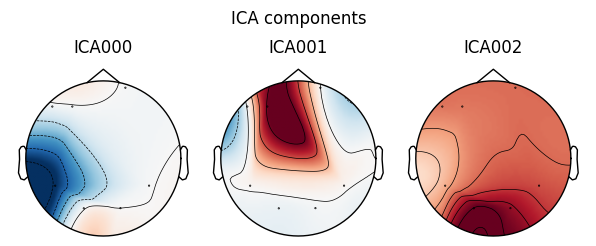

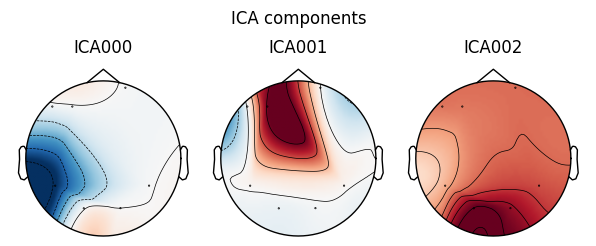

In [ ]:
ica.plot_components()

<ipython-input-13-3137470e0ec8>:3: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  labels = label_components(raw, ica, method="iclabel")
<ipython-input-13-3137470e0ec8>:3: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  labels = label_components(raw, ica, method="iclabel")
<ipython-input-13-3137470e0ec8>:3: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax

Applying ICA to Raw instance
    Transforming to ICA space (3 components)
    Zeroing out 2 ICA components
    Projecting back using 7 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (3 components)
    Zeroing out 2 ICA components
    Projecting back using 7 PCA components


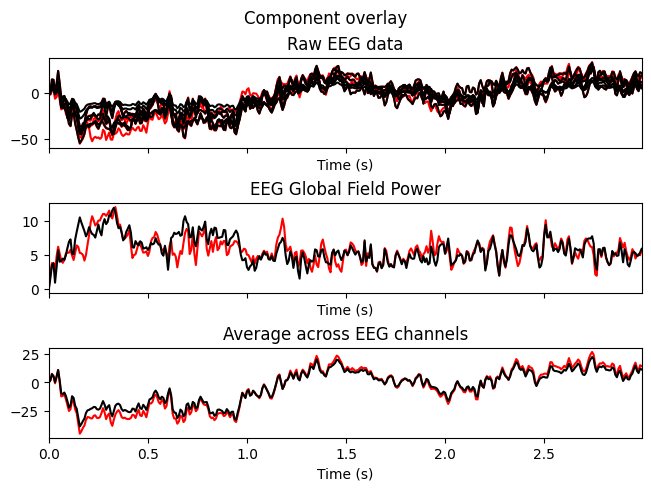

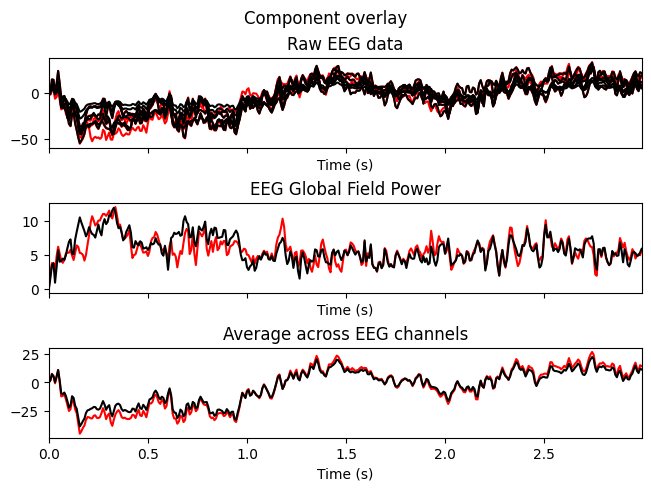

In [ ]:
from mne_icalabel import label_components

labels = label_components(raw, ica, method="iclabel")
artifact_indices = [idx for idx, label in enumerate(labels) if label != "brain"]
ica.exclude = artifact_indices

raw_clean = raw.copy()
ica.apply(raw_clean)
ica.plot_overlay(raw, exclude=ica.exclude, title='Component overlay')

### dataset

In [5]:
### preprocessing function
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import windows
from mne.time_frequency import tfr_array_morlet


def process_eeg_sample(raw, sfreq, ch_names):
    """
    splits a raw object into its window size and does the feature engineering according to the paper to it
    https://www.sciencedirect.com/science/article/abs/pii/S0957417419303926
    """

    data = raw.get_data()
    times = raw.times

    window_length = 15
    step_size = 1

    window_samples = int(window_length * sfreq)
    step_samples = int(step_size * sfreq)

    blackman_window = windows.blackman(window_samples)

    n_windows = (data.shape[1] - window_samples) // step_samples + 1

    # Prepare for STFT
    n_channels = data.shape[0]
    n_fft = 1024

    # Initialize spectrogram array
    spectrograms = np.zeros((n_channels, n_windows, n_fft//2 + 1))

    # Calculate STFT for each channel
    for ch_idx in range(n_channels):
        for win_idx in range(n_windows):
            # Extract window
            start_idx = win_idx * step_samples
            end_idx = start_idx + window_samples
            window_data = data[ch_idx, start_idx:end_idx]

            # Apply Blackman window
            windowed_data = window_data * blackman_window

            # Calculate FFT
            fft_result = np.fft.rfft(windowed_data, n=n_fft)

            # Calculate power spectrum
            power_spectrum = np.abs(fft_result)**2

            # Store in spectrogram
            spectrograms[ch_idx, win_idx, :] = power_spectrum

    # Calculate frequency bins
    freqs = np.fft.rfftfreq(n_fft, d=1/sfreq)

    # Bin into 0.5 Hz bands (from 0 to 18 Hz)
    bin_size = 0.5
    max_freq = 18.0
    n_bins = int(max_freq / bin_size)

    binned_spectrograms = np.zeros((n_channels, n_windows, n_bins))

    # Fixed binning approach
    for ch_idx in range(n_channels):
        for win_idx in range(n_windows):
            for bin_idx in range(n_bins):
                freq_start = bin_idx * bin_size
                freq_end = (bin_idx + 1) * bin_size

                # Find indices of frequencies in this bin
                bin_indices = np.where((freqs >= freq_start) & (freqs < freq_end))[0]

                if len(bin_indices) > 0:
                    # Average power in this frequency bin
                    binned_spectrograms[ch_idx, win_idx, bin_idx] = np.mean(
                        spectrograms[ch_idx, win_idx, bin_indices])

    # Apply 15-second running average for temporal smoothing
    smooth_window = 15  # in steps (since each step is 1 second)
    smoothed_spectrograms = np.zeros_like(binned_spectrograms)

    for ch_idx in range(n_channels):
        for freq_idx in range(n_bins):
            # Use convolution for running average
            kernel = np.ones(smooth_window) / smooth_window
            smoothed_spectrograms[ch_idx, :, freq_idx] = np.convolve(
                binned_spectrograms[ch_idx, :, freq_idx], kernel, mode='same')

    # Convert to decibels
    # Add small constant to avoid log(0)
    db_spectrograms = 10 * np.log10(smoothed_spectrograms + 1e-10)

    # Create feature vectors
    n_features = n_channels * n_bins
    features = np.zeros((n_windows, n_features))

    for win_idx in range(n_windows):
        # Flatten the spectrograms for this time point
        features[win_idx, :] = db_spectrograms[:, win_idx, :].flatten()


    # single sample has shape (586, 252) = (windows, dims), dims = bin_size 0.5 * n_frequenceis 18 * n_channels 7
    return features


In [6]:
### dataset construction (4min)
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.utils import shuffle

def process_dataset(raw_list, info_list, sfreq, channels):
    """
    takes:
    - raw_list (list of mne raw objects)
    - info_list (list of dicts with label and subject_id)

    returns same length array (each a single sample divided into the appropriate window)
    - features
    - labels
    - subject
    """

    all_features = []
    all_labels = []
    subject_ids = []

    for i, raw in tqdm(enumerate(raw_list)):
        features = process_eeg_sample(raw, sfreq, channels)

        label = info_list[i]["label"]
        subject_id = info_list[i]["subject_id"]

        labels = np.full(features.shape[0], label)
        subjects = np.full(features.shape[0], subject_id)

        all_features.append(features)
        all_labels.append(labels)
        subject_ids.append(subjects)

    X = np.vstack(all_features)
    y = np.concatenate(all_labels)
    subjects = np.concatenate(subject_ids)

    return X, y, subjects

if all(os.path.exists(IO_PATH+path+".npy") for path in ["xtr", "ytr", "xte", "yte", "xva", "yva"]):
    print("Loading preprocessed data...")
    X_train = np.load(IO_PATH+"xtr.npy")
    y_train = np.load(IO_PATH+"ytr.npy")
    X_test = np.load(IO_PATH+"xte.npy")
    y_test = np.load(IO_PATH+"yte.npy")
    X_val = np.load(IO_PATH+"xva.npy")
    y_val = np.load(IO_PATH+"yva.npy")

else:
    print("Preprocessing data...")

    if not os.path.exists(IO_PATH):
        os.mkdir(IO_PATH)

    X_all, y_all, subjects_all = process_dataset(raw_list, info_list, sfreq, channels)

    X_test = X_all[subjects_all == 5]
    y_test = y_all[subjects_all == 5]

    X_rest = X_all[subjects_all != 5]
    y_rest = y_all[subjects_all != 5]
    subjects_rest = subjects_all[subjects_all != 5]

    X_train, X_val, y_train, y_val = train_test_split(
        X_rest, y_rest, test_size=0.2, random_state=seed, stratify=y_rest
    )

    X_test, y_test = shuffle(X_test, y_test, random_state=seed)

    if not os.path.exists(IO_PATH):
        os.mkdir(IO_PATH)

    np.save(IO_PATH+"xtr", X_train)
    np.save(IO_PATH+"ytr", y_train)
    np.save(IO_PATH+"xte", X_test)
    np.save(IO_PATH+"yte", y_test)
    np.save(IO_PATH+"xva", X_val)
    np.save(IO_PATH+"yva", y_val)

print(f"Train size: {X_train.shape[0]}, Val size: {X_val.shape[0]}, Test size: {X_test.shape[0]}")
print(f"Train label distribution: {np.unique(y_train, return_counts=True)}")
print(f"Val label distribution: {np.unique(y_val, return_counts=True)}")
print(f"Test label distribution: {np.unique(y_test, return_counts=True)}")

Loading preprocessed data...
Train size: 28028, Val size: 7008, Test size: 7032
Train label distribution: (array([0, 1, 2]), array([9376, 9376, 9276]))
Val label distribution: (array([0, 1, 2]), array([2344, 2344, 2320]))
Test label distribution: (array([0, 1, 2]), array([2344, 2344, 2344]))


### custom collected data (extra-device, extra-subject)

In [7]:
# we expect 128Hz
focused_buffer = np.load(IO_PATH+"focused.npy")
unfocused_buffer = np.load(IO_PATH+"unfocused.npy")

focused_object = construct_mne_raw(focused_buffer, channels, sfreq)
focused_info = {"subject_id": 999, "trial_id": 999, "label": 0, "label_text": "focused"}
unfocused_object = construct_mne_raw(unfocused_buffer, channels, sfreq)
unfocused_info = {"subject_id": 999, "trial_id": 999, "label": 1, "label_text": "unfocused"}

# we assume that the data that is in that file follows the channels that we set here as the ones used
X_own, y_own, subjects_own = process_dataset(
    [focused_object, unfocused_object],
    [focused_info, unfocused_info],
    sfreq,
    channels
)

cls()

print(focused_buffer.shape)

(7, 5120)


### fancy graphs for testing and comparing

In [34]:
def get_subset(raw:mne.io.Raw, n_seconds=5):
    """
    returns the same raw object but only with the last n_seconds seconds, if shorter, will throw a warning and return the exact same
    - has to have sfreq set in the info object
    """

    sfreq = raw.info['sfreq']
    n_samples = int(n_seconds * sfreq)
    total_samples = raw.n_times

    if total_samples <= n_samples:
        print(f"Warning: Raw object contains only {total_samples/sfreq:.2f} seconds, which is less than {n_seconds} seconds.")
        return raw.copy()

    start_sample = total_samples - n_samples
    raw_last_5s = raw.copy().crop(tmin=start_sample/sfreq)
    return raw_last_5s


# - must all be focused
raw_own = focused_object
info_raw_own = focused_info

raw = get_subset(raw_list[0])
info = info_list[0]
print(info)

raw_extra = get_subset(raw_list[66])
info_extra = info_list[66]
print(info_extra)


def get_channel_locations_from_mne(raw):
    """
    make sure montage is set
    """

    pos_3d = raw.get_montage().get_positions()['ch_pos']
    ch_names = raw.ch_names

    location_dict = {}
    for ch in ch_names:
        if ch in pos_3d:
            x, y, _ = pos_3d[ch]
            location_dict[ch] = (x, y)

    return location_dict


montage = mne.channels.make_standard_montage("standard_1020")
raw.set_montage(montage)
raw_own.set_montage(montage)
raw_extra.set_montage(montage)
# fig_topo = raw.plot_sensors(show_names=True)

STEW_CHANNEL_LOCATION_DICT = get_channel_locations_from_mne(raw)
CHANNEL_NAMES = list(STEW_CHANNEL_LOCATION_DICT.keys())
print(STEW_CHANNEL_LOCATION_DICT)

{'subject_id': 1, 'trial_id': 3, 'label': 0, 'label_text': 'focused'}
{'subject_id': 5, 'trial_id': 33, 'label': 0, 'label_text': 'focused'}
{'F7': (np.float64(-0.07187662505917264), np.float64(0.07310352742670875)), 'F3': (np.float64(-0.05180903841183724), np.float64(0.08668789888287941)), 'P7': (np.float64(-0.07445796452347851), np.float64(-0.042123164958505765)), 'O1': (np.float64(-0.03157355787465608), np.float64(-0.08056835212663661)), 'O2': (np.float64(0.027683100559624117), np.float64(-0.08048883980936473)), 'P8': (np.float64(0.07103247088902218), np.float64(-0.04225997601209522)), 'AF4': (np.float64(0.0342298581732583), np.float64(0.10981127208682755))}


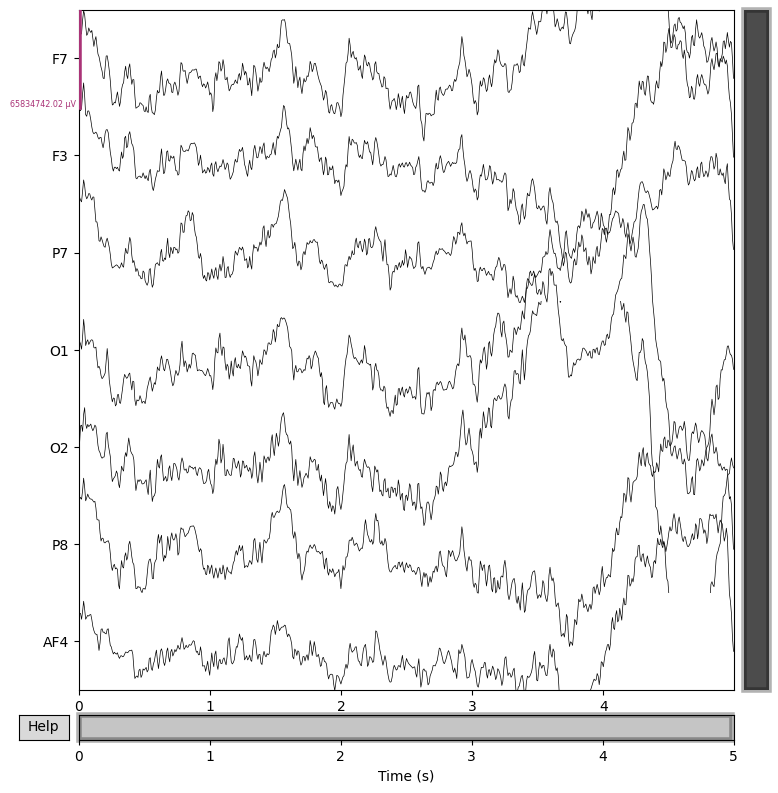

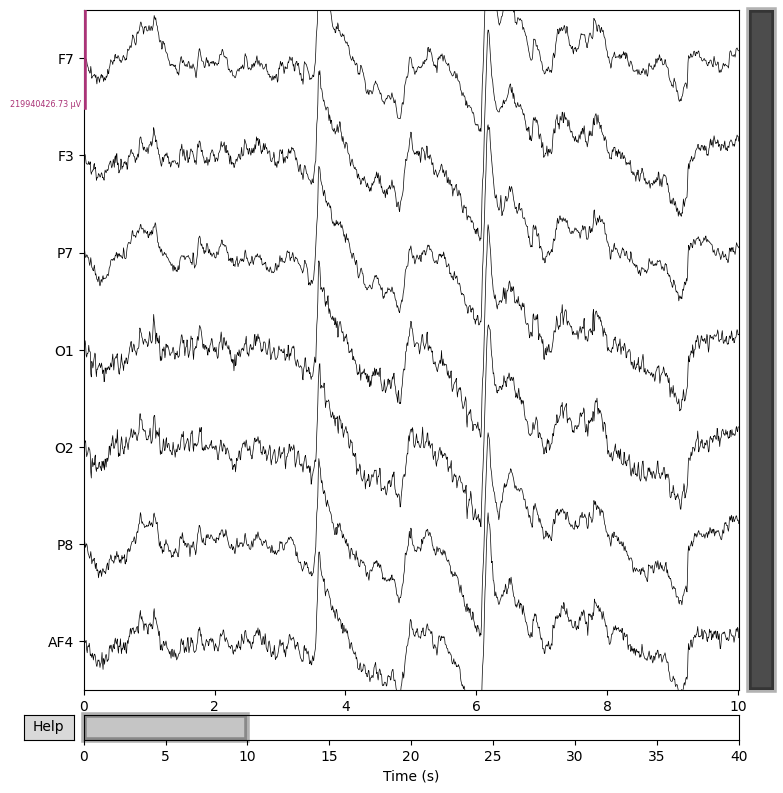

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 5.000 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).


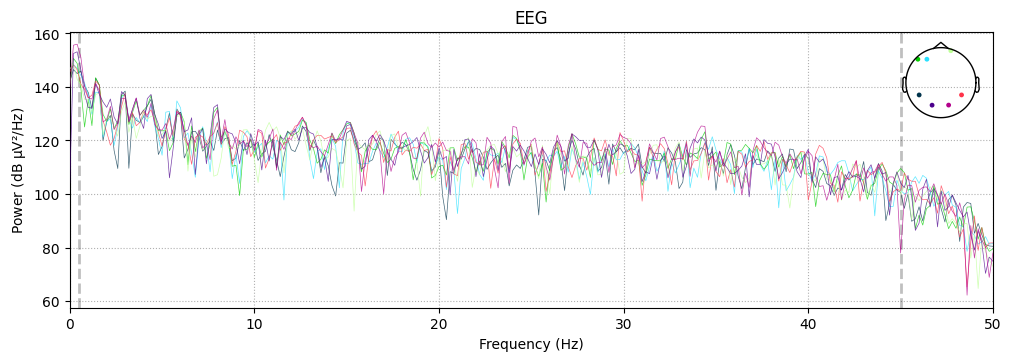

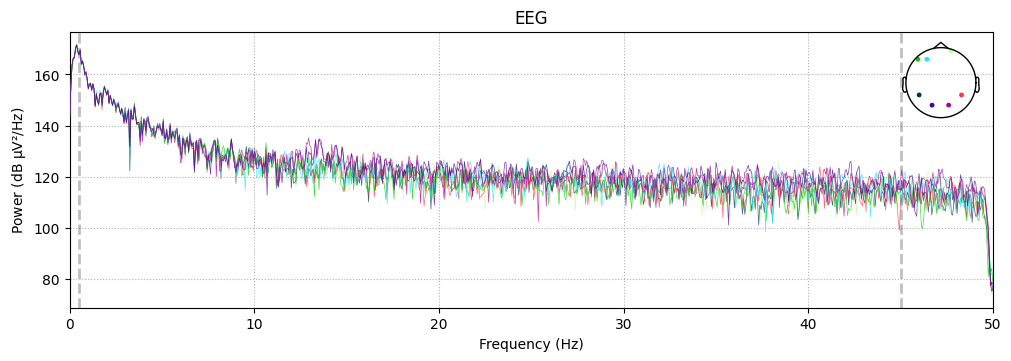

In [35]:
import matplotlib.pyplot as plt

# plot raw graph
fig = raw.plot(duration=10, n_channels=20, scalings='auto', title='Raw Data')
fig = raw_own.plot(duration=10, n_channels=20, scalings='auto', title='Raw Data')

# plot power spectral density
fig_psd = raw.plot_psd(fmax=50)
fig_psd = raw_own.plot_psd(fmax=50)

<ipython-input-30-1644202229>:4: UserWarning: nperseg = 1920 is greater than input length  = 640, using nperseg = 640
  f, t, Sxx = signal.spectrogram(


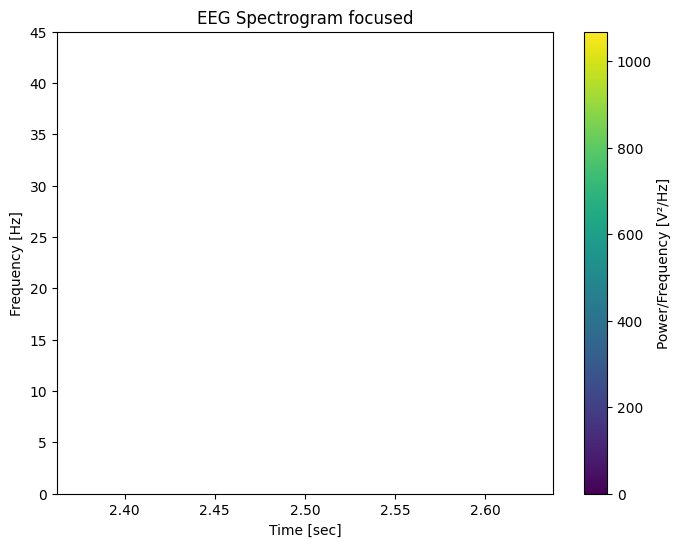

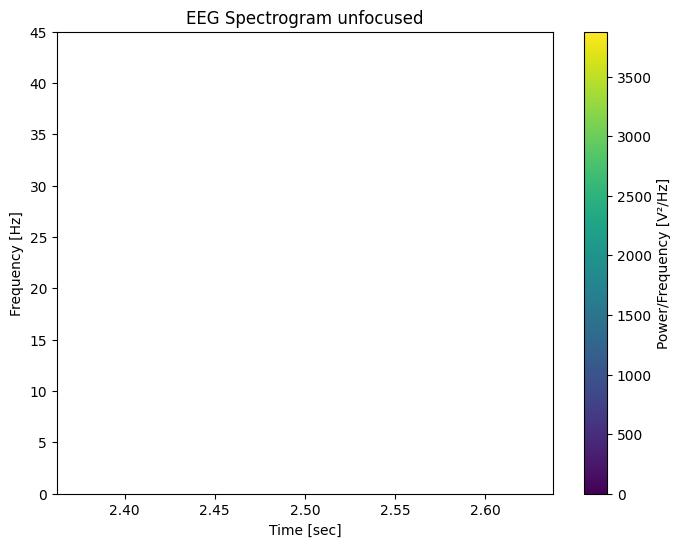

In [30]:
from scipy import signal

def create_spectogram(raw_data):
    f, t, Sxx = signal.spectrogram(
        raw_data,
        fs=128,              # Sampling rate
        nperseg=1920,         # Window size (15 second at 128 Hz)
        noverlap=0,         # 0% overlap
        nfft=1920,            # Length of FFT
        detrend='constant',  # Remove mean from each segment
        window='hann'        # Apply Hann window to reduce spectral leakage
    )
    return f, t, Sxx

def plot_spectogram(f, t, Sxx, label):
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(t, f, Sxx, shading='gouraud', cmap='viridis')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title(f'EEG Spectrogram {label}')
    plt.colorbar(label='Power/Frequency [V²/Hz]')
    plt.ylim(0, 45)  # Limit to frequencies below 45 Hz
    plt.show()


# --- first channel AF3
channel_idx = 0

raw_data = raw.get_data()[channel_idx]
f, t, Sxx = create_spectogram(raw_data)
plot_spectogram(f, t, Sxx, info["label_text"])

raw_data = raw_own.get_data()[channel_idx]
f, t, Sxx = create_spectogram(raw_data)
plot_spectogram(f, t, Sxx, info_own["label_text"])

Analyzing 7 common channels
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).

=== Device Difference Analysis ===
Max PCA angle difference: 86.79° (Threshold: 45°)
Max frequency band difference: 10.75 dB (Threshold: 10 dB)
Mean SNR difference: 3.19 dB (Threshold: 6 dB)
Mean channel correlation: -0.22 (Threshold: 0.5)

Thresholds exceeded:
- PCA angles > 45°: Yes
- Frequency diff > 10dB: Yes
- SNR diff > 6dB: No
- Correlation < 0.5: Yes


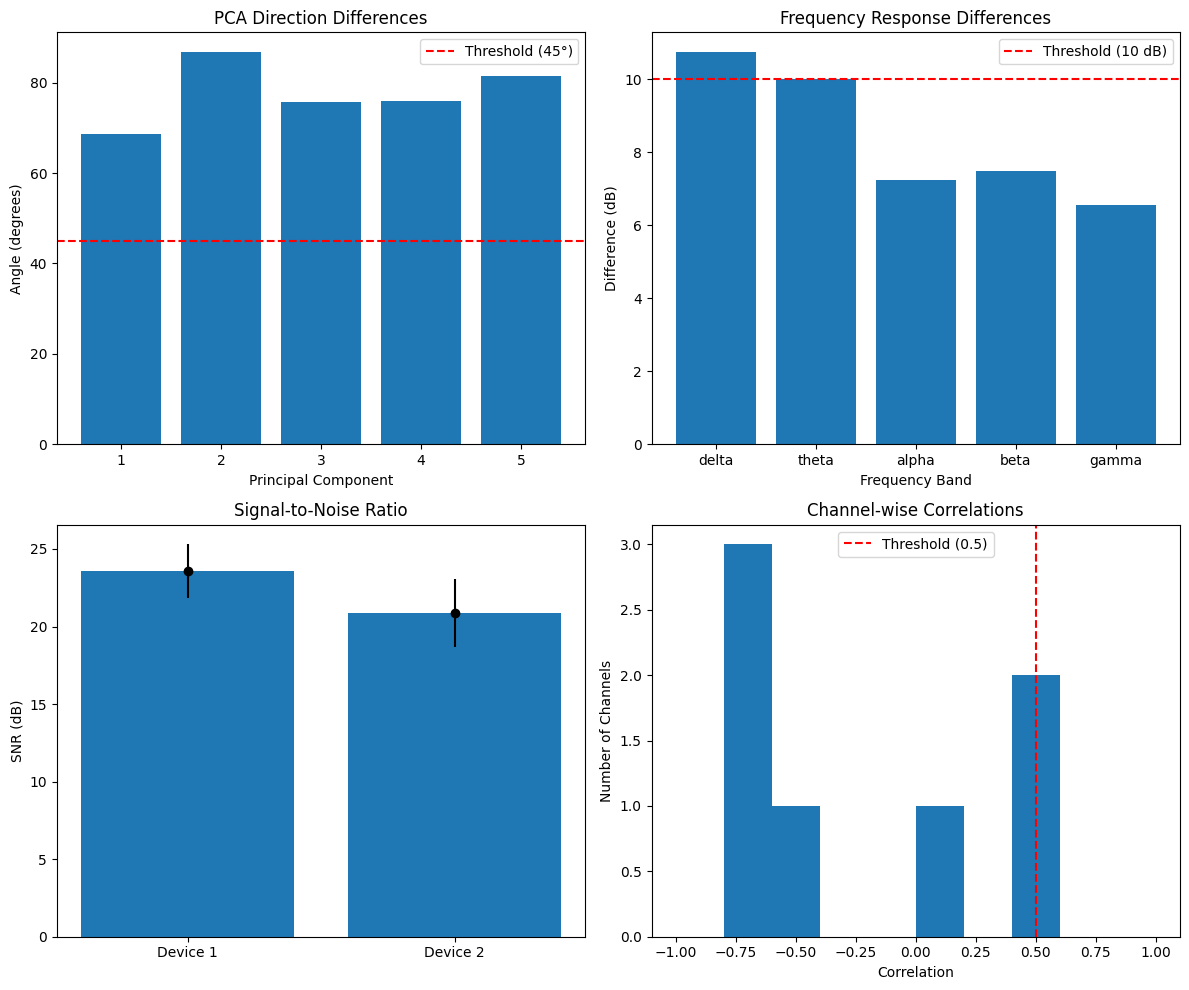

{'pc_angles': [np.float64(68.67935952832313), np.float64(86.79486757611038), np.float64(75.6102157646417), np.float64(75.86365450684029), np.float64(81.4646501019878)], 'max_pc_angle': np.float64(86.79486757611038), 'pc_angle_threshold_exceeded': True, 'freq_diffs': {'delta': np.float64(10.751169124425296), 'theta': np.float64(10.016163522195143), 'alpha': np.float64(7.227935230267654), 'beta': np.float64(7.500884201547874), 'gamma': np.float64(6.555230530957062)}, 'max_freq_diff': np.float64(10.751169124425296), 'freq_diff_threshold_exceeded': True, 'snr_diff': np.float64(3.18992280671713), 'snr_diff_threshold_exceeded': np.False_, 'channel_correlations': [np.float64(0.4020495041815764), np.float64(0.06407017072714188), np.float64(0.5200261012565591), np.float64(-0.6767349484520996), np.float64(-0.6455810022398495), np.float64(-0.5733742741423439), np.float64(-0.6609533425593892)], 'mean_correlation': np.float64(-0.22435682731834353), 'correlation_threshold_exceeded': np.True_}
Analyz

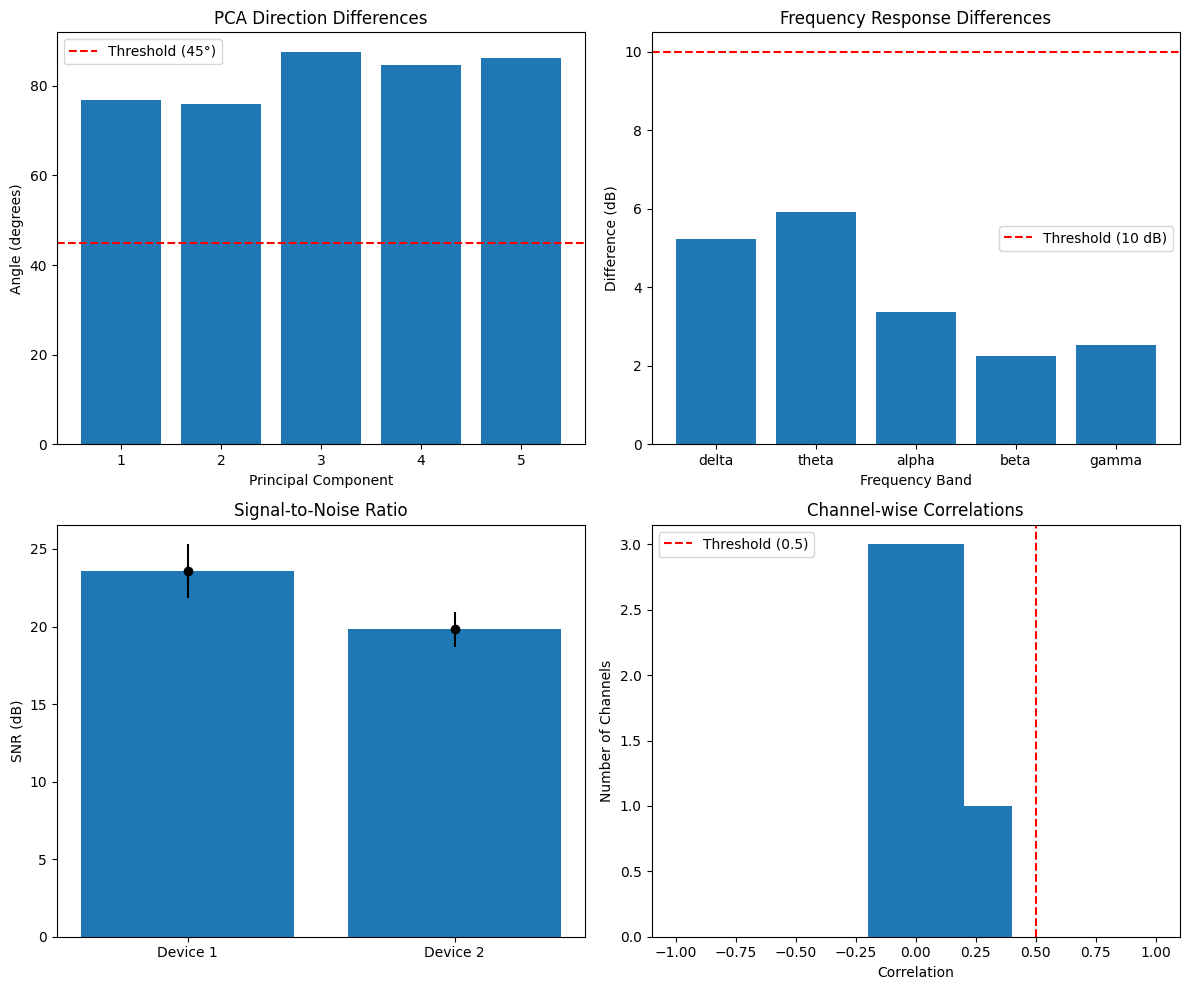

{'pc_angles': [np.float64(76.8276241561833), np.float64(75.9449810129707), np.float64(87.57690126153366), np.float64(84.5960590559949), np.float64(86.23680161055435)], 'max_pc_angle': np.float64(87.57690126153366), 'pc_angle_threshold_exceeded': True, 'freq_diffs': {'delta': np.float64(5.237808664548677), 'theta': np.float64(5.929865200950799), 'alpha': np.float64(3.367259235419523), 'beta': np.float64(2.2587356884852707), 'gamma': np.float64(2.5245599356131327)}, 'max_freq_diff': np.float64(5.929865200950799), 'freq_diff_threshold_exceeded': False, 'snr_diff': np.float64(3.737872781221083), 'snr_diff_threshold_exceeded': np.False_, 'channel_correlations': [np.float64(-0.0317656301854755), np.float64(0.04106917426187809), np.float64(-0.0051561429042249855), np.float64(0.08110883909799613), np.float64(0.08746058241441187), np.float64(-0.05211456882538018), np.float64(0.2762231340655691)], 'mean_correlation': np.float64(0.056689341132110646), 'correlation_threshold_exceeded': np.True_}


In [36]:
import mne
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import pearsonr

def compare_eeg_devices(raw1:mne.io.Raw, raw2:mne.io.Raw):
    freq_bands = {
        'delta': (1, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'beta': (13, 30),
        'gamma': (30, 45)
    }

    # only use common channels (which should be all if the same)
    common_channels = list(set(raw1.ch_names).intersection(set(raw2.ch_names)))

    print(f"Analyzing {len(common_channels)} common channels")

    # Pick common channels and get data
    data1 = raw1.copy().pick_channels(common_channels).get_data()
    data2 = raw2.copy().pick_channels(common_channels).get_data()

    # Ensure same sampling rate for frequency analysis
    sfreq1 = raw1.info['sfreq']
    sfreq2 = raw2.info['sfreq']

    if sfreq1 != sfreq2:
        print(f"Warning: Different sampling rates ({sfreq1} Hz vs {sfreq2} Hz)")
        # Use the lower sampling rate for analysis
        target_sfreq = min(sfreq1, sfreq2)
        if sfreq1 > target_sfreq:
            raw1_resampled = raw1.copy().resample(target_sfreq)
            data1 = raw1_resampled.pick_channels(common_channels).get_data()
        if sfreq2 > target_sfreq:
            raw2_resampled = raw2.copy().resample(target_sfreq)
            data2 = raw2_resampled.pick_channels(common_channels).get_data()
        sfreq = target_sfreq
    else:
        sfreq = sfreq1

    # Ensure same data length
    min_length = min(data1.shape[1], data2.shape[1])
    data1 = data1[:, :min_length]
    data2 = data2[:, :min_length]

    results = {}

    # 1. PCA direction differences
    pca1 = PCA(n_components=min(5, len(common_channels)))
    pca2 = PCA(n_components=min(5, len(common_channels)))

    pca1.fit(data1)
    pca2.fit(data2)

    pc_angles = []
    for i in range(min(pca1.components_.shape[0], pca2.components_.shape[0])):
        # Calculate angle between principal components
        cos_angle = np.abs(np.dot(pca1.components_[i], pca2.components_[i])) / (
            np.linalg.norm(pca1.components_[i]) * np.linalg.norm(pca2.components_[i])
        )
        angle_degrees = np.arccos(min(cos_angle, 1.0)) * 180 / np.pi
        pc_angles.append(angle_degrees)

    results['pc_angles'] = pc_angles
    results['max_pc_angle'] = max(pc_angles)
    results['pc_angle_threshold_exceeded'] = any(angle > 45 for angle in pc_angles)

    # 2. Frequency response differences
    freq_diffs = {}
    for band_name, (fmin, fmax) in freq_bands.items():
        # Compute power spectral density
        f1, psd1 = signal.welch(data1, fs=sfreq, nperseg=min(1024, min_length))
        f2, psd2 = signal.welch(data2, fs=sfreq, nperseg=min(1024, min_length))

        # Find indices for the frequency band
        idx1 = np.logical_and(f1 >= fmin, f1 <= fmax)
        idx2 = np.logical_and(f2 >= fmin, f2 <= fmax)

        # Calculate mean power in dB for each channel
        power1_db = 10 * np.log10(np.mean(psd1[:, idx1], axis=1))
        power2_db = 10 * np.log10(np.mean(psd2[:, idx2], axis=1))

        # Calculate difference
        diff_db = np.abs(power1_db - power2_db)
        max_diff_db = np.max(diff_db)
        freq_diffs[band_name] = max_diff_db

    results['freq_diffs'] = freq_diffs
    results['max_freq_diff'] = max(freq_diffs.values())
    results['freq_diff_threshold_exceeded'] = any(diff > 10 for diff in freq_diffs.values())

    # 3. SNR differences
    # Estimate SNR using variance of signal vs. high frequency noise
    def estimate_snr(data, sfreq):
        # Use high frequency band as noise estimate
        f, psd = signal.welch(data, fs=sfreq, nperseg=min(1024, data.shape[1]))
        signal_idx = np.logical_and(f >= 1, f <= 40)  # Main EEG bands
        noise_idx = f > 40  # Higher frequencies as noise estimate

        if not np.any(noise_idx):
            # If sampling rate is too low for noise estimate
            noise_idx = f > 30

        signal_power = np.mean(psd[:, signal_idx], axis=1)
        noise_power = np.mean(psd[:, noise_idx], axis=1) if np.any(noise_idx) else np.var(data, axis=1) * 0.1

        # Avoid division by zero
        noise_power = np.maximum(noise_power, 1e-10)

        snr_db = 10 * np.log10(signal_power / noise_power)
        return snr_db

    snr1 = estimate_snr(data1, sfreq)
    snr2 = estimate_snr(data2, sfreq)

    snr_diff = np.abs(snr1 - snr2)
    results['snr_diff'] = np.mean(snr_diff)
    results['snr_diff_threshold_exceeded'] = np.mean(snr_diff) > 6

    # 4. Channel-wise correlation
    correlations = []
    for ch_idx in range(len(common_channels)):
        corr, _ = pearsonr(data1[ch_idx], data2[ch_idx])
        correlations.append(corr)

    results['channel_correlations'] = correlations
    results['mean_correlation'] = np.mean(correlations)
    results['correlation_threshold_exceeded'] = np.mean(correlations) < 0.5

    # Summary
    print("\n=== Device Difference Analysis ===")
    print(f"Max PCA angle difference: {results['max_pc_angle']:.2f}° (Threshold: 45°)")
    print(f"Max frequency band difference: {results['max_freq_diff']:.2f} dB (Threshold: 10 dB)")
    print(f"Mean SNR difference: {results['snr_diff']:.2f} dB (Threshold: 6 dB)")
    print(f"Mean channel correlation: {results['mean_correlation']:.2f} (Threshold: 0.5)")

    print("\nThresholds exceeded:")
    print(f"- PCA angles > 45°: {'Yes' if results['pc_angle_threshold_exceeded'] else 'No'}")
    print(f"- Frequency diff > 10dB: {'Yes' if results['freq_diff_threshold_exceeded'] else 'No'}")
    print(f"- SNR diff > 6dB: {'Yes' if results['snr_diff_threshold_exceeded'] else 'No'}")
    print(f"- Correlation < 0.5: {'Yes' if results['correlation_threshold_exceeded'] else 'No'}")

    # Create visualization
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # Plot PCA angles
    axs[0, 0].bar(range(1, len(pc_angles)+1), pc_angles)
    axs[0, 0].axhline(y=45, color='r', linestyle='--', label='Threshold (45°)')
    axs[0, 0].set_xlabel('Principal Component')
    axs[0, 0].set_ylabel('Angle (degrees)')
    axs[0, 0].set_title('PCA Direction Differences')
    axs[0, 0].legend()

    # Plot frequency differences
    bands = list(freq_diffs.keys())
    diffs = list(freq_diffs.values())
    axs[0, 1].bar(bands, diffs)
    axs[0, 1].axhline(y=10, color='r', linestyle='--', label='Threshold (10 dB)')
    axs[0, 1].set_xlabel('Frequency Band')
    axs[0, 1].set_ylabel('Difference (dB)')
    axs[0, 1].set_title('Frequency Response Differences')
    axs[0, 1].legend()

    # Plot SNR
    axs[1, 0].bar(['Device 1', 'Device 2'], [np.mean(snr1), np.mean(snr2)])
    axs[1, 0].errorbar(['Device 1', 'Device 2'], [np.mean(snr1), np.mean(snr2)],
                      yerr=[np.std(snr1), np.std(snr2)], fmt='o', color='black')
    axs[1, 0].set_ylabel('SNR (dB)')
    axs[1, 0].set_title('Signal-to-Noise Ratio')

    # Plot correlations
    axs[1, 1].hist(correlations, bins=10, range=(-1, 1))
    axs[1, 1].axvline(x=0.5, color='r', linestyle='--', label='Threshold (0.5)')
    axs[1, 1].set_xlabel('Correlation')
    axs[1, 1].set_ylabel('Number of Channels')
    axs[1, 1].set_title('Channel-wise Correlations')
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()

    return results


results = compare_eeg_devices(raw, raw_own)
print(results)

results = compare_eeg_devices(raw, raw_extra)
print(results)

### models

In [ ]:
import joblib
from sklearn.preprocessing import StandardScaler

# takes seconds to train
scaler_path = MODEL_SAVE_PATH + "scaler.pkl"
if os.path.exists(scaler_path):
    scaler = joblib.load(scaler_path)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_val_scaled = scaler.transform(X_val)
    X_own_scaled = scaler.transform(X_own)

else:
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_val_scaled = scaler.transform(X_val)

joblib.dump(scaler, scaler_path)

['/content/drive/MyDrive/datasets/FOCUS/model/02_stat/scaler.pkl']

In [ ]:
# from sklearn.svm import SVC

# from sklearn.linear_model import SGDClassifier

# from sklearn.calibration import CalibratedClassifierCV

# !pip install lightgbm
# import lightgbm as lgb

# from sklearn.ensemble import GradientBoostingClassifier

from sklearn.ensemble import HistGradientBoostingClassifier


classifiers = [] # 3 binary classifiers


for state in range(3):  # 0: focused, 1: unfocused, 2: drowsy
    model_path = MODEL_SAVE_PATH + f"stat_{state}.pkl"

    if os.path.exists(model_path):
        print(f"Loading {state}")
        clf = joblib.load(model_path)

    else:
        print(f"Training {state}")


        # - comment out
        # clf = SVC(
        #     kernel='linear',
        #     C=1.0,
        #     probability=True,
        #     random_state=seed
        # )
        # clf = SGDClassifier(
        #     loss='log_loss',
        #     penalty='l2',
        #     random_state=seed
        # )
        # clf = lgb.LGBMClassifier(
        #     n_estimators=100,
        #     learning_rate=0.1,
        #     max_depth=-1,
        #     num_leaves=31,
        #     random_state=seed
        # )
        # clf = GradientBoostingClassifier(n_estimators=100,learning_rate=0.1,max_depth=3,random_state=seed, warm_start=True)
        clf = HistGradientBoostingClassifier(max_iter=100,learning_rate=0.1,max_depth=3, random_state=seed, warm_start=True)
        # -


        binary_labels = (y_train == state).astype(int)  # Create binary labels (state vs. rest)
        clf.fit(X_train_scaled, binary_labels)
        joblib.dump(clf, model_path)


    # Evaluate on train subset - 7000 is the size of val and test
    binary_labels = (y_train[:7000] == state).astype(int)
    accuracy = clf.score(X_train_scaled[:7000], binary_labels)
    print(f"State {state} classifier accuracy (train): {accuracy:.4f}")

    # Evaluate on val set (intra-subject)
    binary_labels = (y_val == state).astype(int)
    accuracy = clf.score(X_val_scaled, binary_labels)
    print(f"State {state} classifier accuracy (val): {accuracy:.4f}")

    # evaluate on test set (extra-subject)
    binary_labels = (y_test == state).astype(int)
    accuracy = clf.score(X_test_scaled, binary_labels)
    print(f"State {state} classifier accuracy (test): {accuracy:.4f}")

    # evaluate on own set (extra-subject & extra-device with "shitty" recording)
    binary_labels = (y_own == state).astype(int)
    accuracy = clf.score(X_own_scaled, binary_labels)
    print(f"State {state} classifier accuracy (own): {accuracy:.4f}")


    classifiers.append(clf)


# ---------------------- (40min per model) - SVC(kernel='linear', C=1.0, probability=True)
# Loading 0
# State 0 classifier accuracy (train): 0.9080
# State 0 classifier accuracy (val): 0.9037
# State 0 classifier accuracy (test): 0.8022
# Loading 1
# State 1 classifier accuracy (train): 0.7831
# State 1 classifier accuracy (val): 0.7748
# State 1 classifier accuracy (test): 0.6443
# Loading 2
# State 2 classifier accuracy (train): 0.9089
# State 2 classifier accuracy (val): 0.9000
# State 2 classifier accuracy (test): 0.7480

# ---------------------- (almost instant) - SGDClassifier(loss='log_loss', penalty='l2')
# Loading 0
# State 0 classifier accuracy (train): 0.8990
# State 0 classifier accuracy (val): 0.8883
# State 0 classifier accuracy (test): 0.8028
# Loading 1
# State 1 classifier accuracy (train): 0.7573
# State 1 classifier accuracy (val): 0.7486
# State 1 classifier accuracy (test): 0.6452
# Loading 2
# State 2 classifier accuracy (train): 0.8911
# State 2 classifier accuracy (val): 0.8793
# State 2 classifier accuracy (test): 0.7705
# ---------------------- (almost instant) couldnt finetune - lgb.LGBMClassifier(n_estimators=100,learning_rate=0.1,max_depth=-1,num_leaves=31,random_state=seed)
# Training 0
# State 0 classifier accuracy (train): 0.9997
# State 0 classifier accuracy (val): 0.9943
# State 0 classifier accuracy (test): 0.8406
# Training 1
# State 1 classifier accuracy (train): 0.9950
# State 1 classifier accuracy (val): 0.9864
# State 1 classifier accuracy (test): 0.6752
# Training 2
# State 2 classifier accuracy (train): 1.0000
# State 2 classifier accuracy (val): 0.9974
# State 2 classifier accuracy (test): 0.7786
# ---------------------- (8min per model) - GradientBoostingClassifier(n_estimators=100,learning_rate=0.1,max_depth=3,random_state=seed, warm_start=True)
# Training 0
# State 0 classifier accuracy (train): 0.9411
# State 0 classifier accuracy (val): 0.9307
# State 0 classifier accuracy (test): 0.8508
# Training 1
# State 1 classifier accuracy (train): 0.8876
# State 1 classifier accuracy (val): 0.8774
# State 1 classifier accuracy (test): 0.6738
# Training 2
# State 2 classifier accuracy (train): 0.9569
# State 2 classifier accuracy (val): 0.9511
# State 2 classifier accuracy (test): 0.8227
# ---------------------- (almost instant) - HistGradientBoostingClassifier(max_iter=100,learning_rate=0.1,max_depth=3,random_state=seed, warm_start=True)
# Training 0
# State 0 classifier accuracy (train): 0.9410
# State 0 classifier accuracy (val): 0.9346
# State 0 classifier accuracy (test): 0.8507
# Training 1
# State 1 classifier accuracy (train): 0.8857
# State 1 classifier accuracy (val): 0.8787
# State 1 classifier accuracy (test): 0.6745
# Training 2
# State 2 classifier accuracy (train): 0.9549
# State 2 classifier accuracy (val): 0.9479
# State 2 classifier accuracy (test): 0.7959

Loading 0
State 0 classifier accuracy (train): 0.9410
State 0 classifier accuracy (val): 0.9346
State 0 classifier accuracy (test): 0.8507
State 0 classifier accuracy (own): 0.2308
Loading 1
State 1 classifier accuracy (train): 0.8857
State 1 classifier accuracy (val): 0.8787
State 1 classifier accuracy (test): 0.6745
State 1 classifier accuracy (own): 0.4808
Loading 2
State 2 classifier accuracy (train): 0.9549
State 2 classifier accuracy (val): 0.9479
State 2 classifier accuracy (test): 0.7959
State 2 classifier accuracy (own): 0.7115


### val & inference

In [ ]:
### prediction
def pred(features, classifiers, scalar):
    """
    features must be scaled already
    """
    probs = np.zeros((features.shape[0], len(classifiers)))

    for i, clf in enumerate(classifiers):
        probs[:, i] = clf.predict_proba(features)[:, 1]

    return np.argmax(probs, axis=1)

In [ ]:
### testing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def evaluate_model(classifiers, scaler, X, y):
    """
    X must be scaled already, this is how pred expects it
    """
    preds = pred(X, classifiers, scaler)

    # overall performance
    accuracy = accuracy_score(y, preds)
    precision = precision_score(y, preds, average='weighted')
    recall = recall_score(y, preds, average='weighted')
    f1 = f1_score(y, preds, average='weighted')

    class_report = classification_report(y, preds, output_dict=True)

    print(f"Model Evaluation Results:")
    print(f"-------------------------")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    # print("\nClassification Report:")
    # print(class_report)


    # confusion matrix
    cm = confusion_matrix(y, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Focused', 'Unfocused', 'Drowsy'],
                yticklabels=['Focused', 'Unfocused', 'Drowsy'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


    # class-specific performance
    class_metrics = {}
    class_keys = [k for k in class_report.keys() if k in ['0', '1', '2']]
    for key in class_keys:
        class_metrics[int(key)] = { # Convert key back to int for dict key if preferred
            'precision': class_report[key]['precision'],
            'recall': class_report[key]['recall'],
            'f1-score': class_report[key]['f1-score']
        }

    # Create DataFrame from class_metrics and transpose
    metrics_df = pd.DataFrame(class_metrics).T

    # Map the numeric index to meaningful labels if the class is present
    label_map = {0: 'Focused', 1: 'Unfocused', 2: 'Drowsy'}
    # Create a new index based on the keys of the metrics_df index
    metrics_df.index = [label_map[idx] for idx in metrics_df.index]


    plt.figure(figsize=(10, 6))
    metrics_df.plot(kind='bar')
    plt.title('Per-class Performance Metrics')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


    #
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'class_report': class_report
    }

    return metrics

Model Evaluation Results:
-------------------------
Accuracy: 0.6498
Precision: 0.6500
Recall: 0.6498
F1 Score: 0.6162


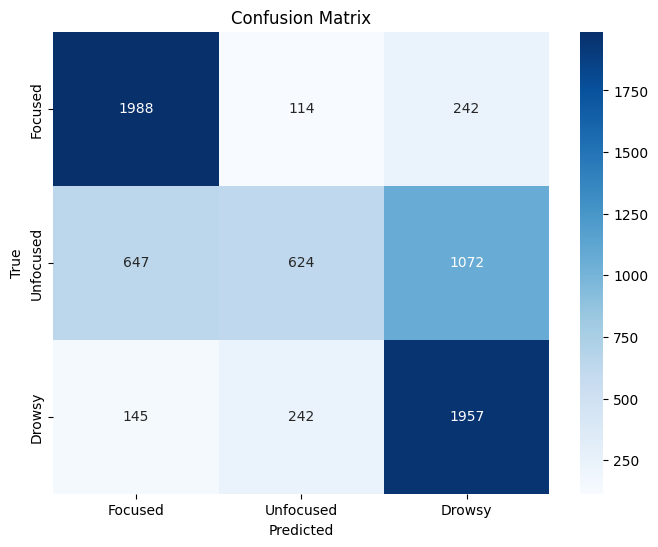

<Figure size 1000x600 with 0 Axes>

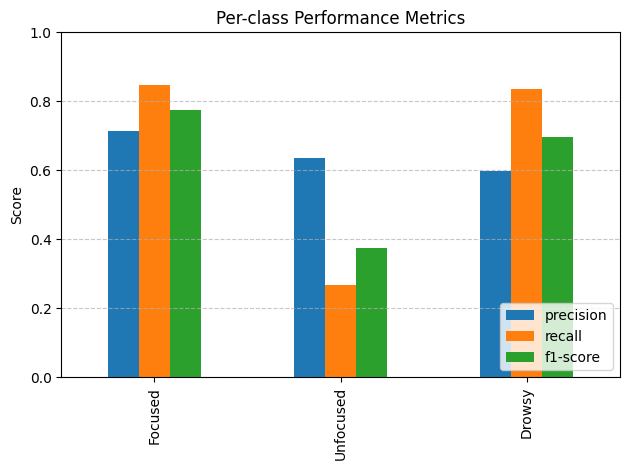

In [ ]:
x = X_test_scaled[:-1]
y = y_test[:-1]
metrics = evaluate_model(classifiers, scaler, x, y)

### destroying test-set

In [ ]:
dirty_classifiers = classifiers[:]  # for sgd with builtin partial_fit

dirty_classifiers = [HistGradientBoostingClassifier(max_iter=100,learning_rate=0.1,max_depth=3, random_state=seed, warm_start=True) for clf in classifiers]

for clf in dirty_classifiers:
    print(clf.get_params())
#     clf.set_params(
#         verbosity=0,
#         n_estimators=20,
#         learning_rate=0.01,
#     )

{'categorical_features': 'from_dtype', 'class_weight': None, 'early_stopping': 'auto', 'interaction_cst': None, 'l2_regularization': 0.0, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_bins': 255, 'max_depth': 3, 'max_features': 1.0, 'max_iter': 100, 'max_leaf_nodes': 31, 'min_samples_leaf': 20, 'monotonic_cst': None, 'n_iter_no_change': 10, 'random_state': 42, 'scoring': 'loss', 'tol': 1e-07, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': True}
{'categorical_features': 'from_dtype', 'class_weight': None, 'early_stopping': 'auto', 'interaction_cst': None, 'l2_regularization': 0.0, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_bins': 255, 'max_depth': 3, 'max_features': 1.0, 'max_iter': 100, 'max_leaf_nodes': 31, 'min_samples_leaf': 20, 'monotonic_cst': None, 'n_iter_no_change': 10, 'random_state': 42, 'scoring': 'loss', 'tol': 1e-07, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': True}
{'categorical_features': 'from_dtype', 'class_weight': None, 'early_stopping': 'au

In [ ]:
# --- use this for own set (extra-subject and -device)
X_test_train, X_test_val, y_test_train, y_test_val = train_test_split(
    X_own_scaled, y_own, test_size=0.1, random_state=seed, stratify=y_own
)

# --- use this for test set (only extra-subject)
# X_test_train, X_test_val, y_test_train, y_test_val = train_test_split(
#     X_test_scaled, y_test, test_size=0.2, random_state=seed, stratify=y_test
# )

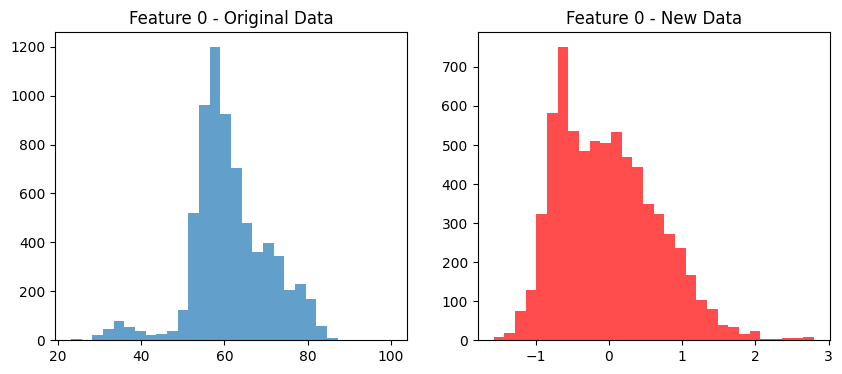

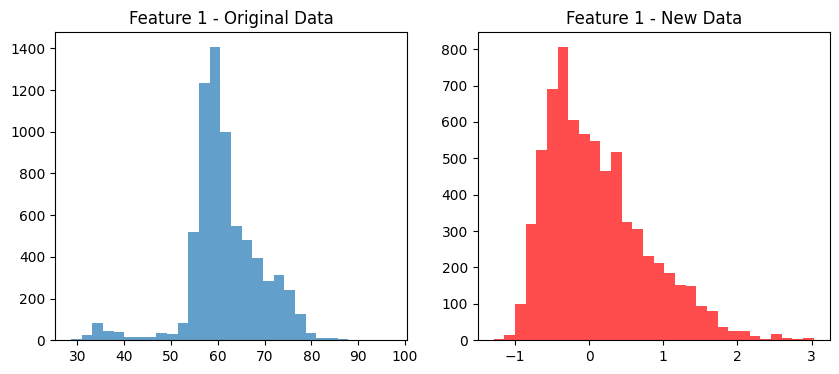

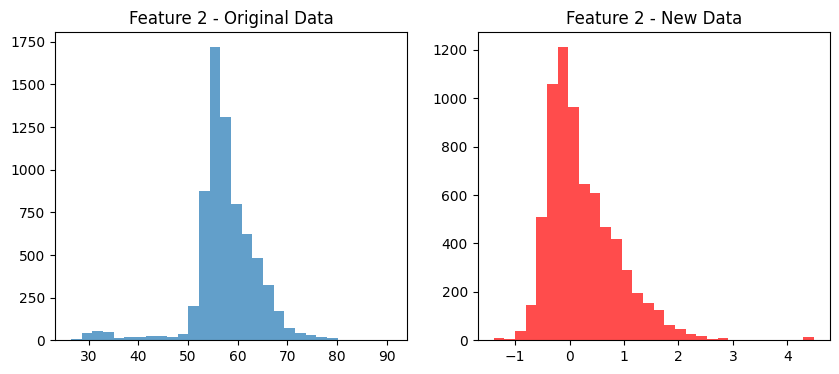

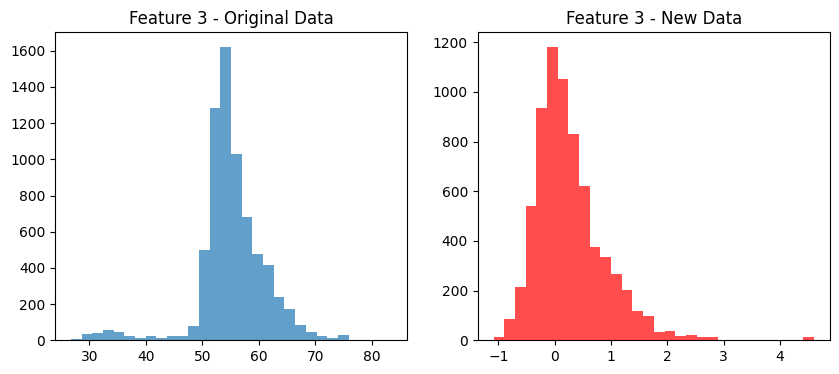

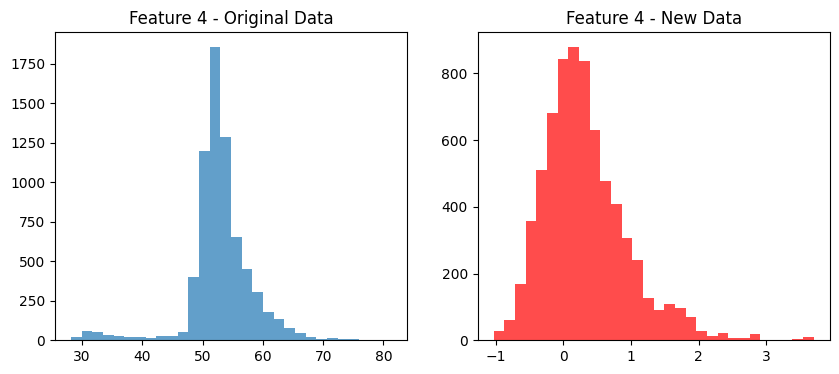

In [ ]:
import matplotlib.pyplot as plt

# Plot distributions of a few key features
for i in range(min(5, X_val_scaled.shape[1])):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(X_val[:, i], bins=30, alpha=0.7, label='Original')
    plt.title(f"Feature {i} - Original Data")

    plt.subplot(1, 2, 2)
    plt.hist(X_test_scaled[:, i], bins=30, alpha=0.7, color='red', label='New')
    plt.title(f"Feature {i} - New Data")
    plt.show()

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

state0_accuracies = []
state1_accuracies = []
state2_accuracies = []
overall_accuracies = []
samples_trained = []


batch_size = 10 # was
n_batches = len(X_test_train) // batch_size

if len(X_test_train) <= batch_size / 2:
    raise ValueError("set must have at least two batches in them")

skf = StratifiedKFold(n_splits=n_batches, shuffle=True, random_state=seed)

# Training loop
for i, indexes in enumerate(skf.split(X_test_train, y_test_train)):
    batch_index = indexes[1]  # Get test indices which are our batch
    x = X_test_train[batch_index]  # Fixed variable name
    y_batch = y_test_train[batch_index]  # Fixed variable name

    current_samples = (i+1) * batch_size
    samples_trained.append(current_samples)

    print(f"--- after {current_samples} samples (thus {current_samples+14} seconds) ---")


    start = time.time()

    for state in range(3):
        clf = dirty_classifiers[state]
        y = (y_batch == state).astype(int)

        # - comment here
        # clf.partial_fit(x, y)

        clf.set_params(max_iter=clf.max_iter + 3, learning_rate=0.001)
        sample_weights = np.ones(len(x)) * 0.1
        clf.fit(x, y, sample_weight=sample_weights)
        # -


        # binary_val_labels = (y_test_val == state).astype(int)
        # accuracy = clf.score(X_test_val, binary_val_labels)
        # print(f"state {state} validation-set classifier accuracy: {accuracy:.4f}")

        binary_val_labels = (y_val == state).astype(int)
        accuracy = clf.score(X_val, binary_val_labels)
        print(f"state {state} test-set (val part) classifier accuracy: {accuracy:.4f}")


        # Store accuracy for plotting
        if state == 0:
            state0_accuracies.append(accuracy)
        elif state == 1:
            state1_accuracies.append(accuracy)
        else:
            state2_accuracies.append(accuracy)


        dirty_classifiers[state] = clf
        model_path = MODEL_SAVE_PATH + f"dirty_stat_{state}.pkl"
        joblib.dump(clf, model_path)


    # Overall accuracy
    # preds = pred(X_test_val, dirty_classifiers, scaler)
    # accuracy = sum(preds == y_test_val) / len(preds)
    # overall_accuracies.append(accuracy)
    # print(f"whole classifier accuracy: {accuracy:.4f}, batch took {time.time() - start} seconds")

    # if current_samples >= 1000:
    #     print("--- !! ending training !! ---")
    #     break


# ------------------------------------------ I actually retrained SVC at first (the incremental makeshift took hours)
# --- after 60 samples (thus 74 seconds) ---
# state 0 classifier accuracy: 0.8486
# state 1 classifier accuracy: 0.7505
# state 2 classifier accuracy: 0.8870
# whole classifier accuracy: 0.7363, batch took 0.9711980819702148 seconds
# --- after 120 samples (thus 134 seconds) ---
# state 0 classifier accuracy: 0.8856
# state 1 classifier accuracy: 0.8145
# state 2 classifier accuracy: 0.9140
# whole classifier accuracy: 0.8031, batch took 1.2570092678070068 seconds
# => reaches 97 at some point

# ------------------------------------------ HGBC with same learning rate (lowering drops it and then stabilizes at 80)
# --- after 60 samples (thus 74 seconds) ---
# state 0 classifier accuracy: 0.8600
# state 1 classifier accuracy: 0.7299
# state 2 classifier accuracy: 0.6304
# whole classifier accuracy: 0.6063, batch took 1.3559234142303467 seconds
# --- after 120 samples (thus 134 seconds) ---
# state 0 classifier accuracy: 0.8571
# state 1 classifier accuracy: 0.7576
# state 2 classifier accuracy: 0.6795
# whole classifier accuracy: 0.6482, batch took 0.7069306373596191 seconds
# => actually start overfitting and falls off

--- after 10 samples (thus 24 seconds) ---
state 0 test-set (val part) classifier accuracy: 0.6655
state 1 test-set (val part) classifier accuracy: 0.6655
state 2 test-set (val part) classifier accuracy: 0.6689
--- after 20 samples (thus 34 seconds) ---
state 0 test-set (val part) classifier accuracy: 0.6655
state 1 test-set (val part) classifier accuracy: 0.6655
state 2 test-set (val part) classifier accuracy: 0.6689
--- after 30 samples (thus 44 seconds) ---
state 0 test-set (val part) classifier accuracy: 0.6655
state 1 test-set (val part) classifier accuracy: 0.6655
state 2 test-set (val part) classifier accuracy: 0.6689
--- after 40 samples (thus 54 seconds) ---
state 0 test-set (val part) classifier accuracy: 0.6655
state 1 test-set (val part) classifier accuracy: 0.6655
state 2 test-set (val part) classifier accuracy: 0.6689


ValueError: x and y must have same first dimension, but have shapes (7,) and (0,)

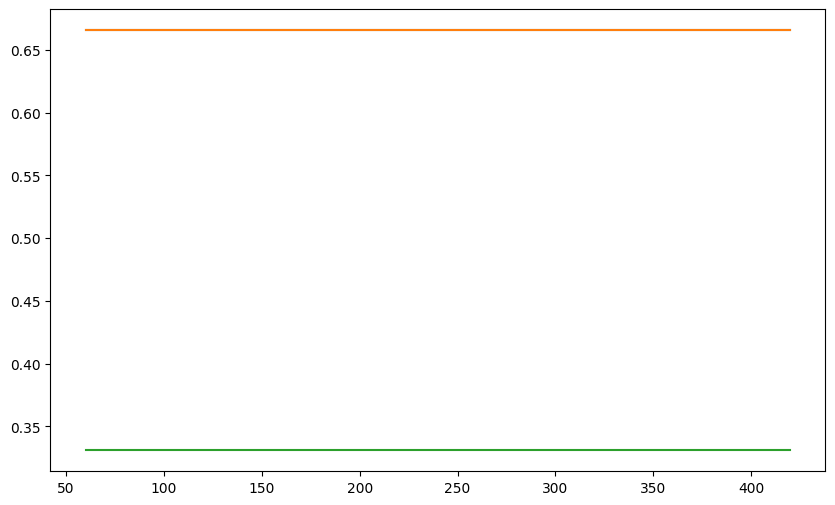

In [ ]:
limit = 7 # -1

# Plot the accuracies
plt.figure(figsize=(10, 6))
plt.plot(samples_trained[:limit], state0_accuracies[:limit], label='State 0 focused')
plt.plot(samples_trained[:limit], state1_accuracies[:limit], label='State 1 unfocused')
plt.plot(samples_trained[:limit], state2_accuracies[:limit], label='State 2 drowsy')
plt.plot(samples_trained[:limit], overall_accuracies[:limit], label='Overall', linewidth=2)
plt.xlabel('Number of Samples Trained')
plt.ylabel('Accuracy')
plt.title('Classifier Accuracy vs. Training Samples')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('accuracy_plot.png')
plt.show()